## STEP-1: Import Libraries

In [2]:
import tensorflow as tf
import os
import sys

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

In [4]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from keras.datasets import cifar10

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [8]:
from keras.optimizers import SGD

## Step-2: Load dataset

In [9]:
(trainX,trainY) , (testX,testY) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [10]:
trainX.shape

(50000, 32, 32, 3)

In [11]:
trainY.shape

(50000, 1)

In [12]:
testX.shape

(10000, 32, 32, 3)

In [13]:
testY.shape

(10000, 1)

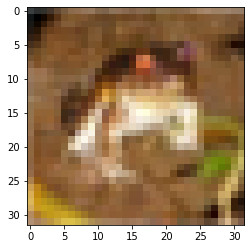

In [14]:
plt.imshow(trainX[0])

In [15]:
trainY[0:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [16]:
count = 0
a = np.zeros(10)
for i in trainY:
  a[i] = a[i] + 1
for i in range(0,len(a)):
  print("Class: ", i , " Count: " , a[i])

Class:  0  Count:  5000.0
Class:  1  Count:  5000.0
Class:  2  Count:  5000.0
Class:  3  Count:  5000.0
Class:  4  Count:  5000.0
Class:  5  Count:  5000.0
Class:  6  Count:  5000.0
Class:  7  Count:  5000.0
Class:  8  Count:  5000.0
Class:  9  Count:  5000.0


## Step-3: Convert each of the elements in the y-data (test and train) to one hot encodings.

In [17]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [18]:
trainY.shape

(50000, 10)

In [19]:
testY.shape

(10000, 10)

In [20]:
trainY[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

## Step-4: Normalize image pixels by dividing by 255

In [21]:
trainX = trainX.astype('float')
trainX = trainX/255.0

In [22]:
testX = testX.astype('float')
testX = testX/255.0

In [23]:
trainX[0][1] 
'''
All values have been normalised between 0 and 1
'''

'\nAll values have been normalised between 0 and 1\n'

## Step-5: Build Model

In [24]:
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
with tpu_strategy.scope():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    optimizer = SGD(momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model

In [26]:
model.layers

## Step-6: Merge the training dataset

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((trainX,trainY))
dataset = dataset.cache()
dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
dataset = dataset.repeat()
dataset = dataset.batch(64, drop_remainder=True)

In [31]:
trainX.shape[0]

50000

In [32]:
steps = trainX.shape[0]/64

In [33]:
steps = int(steps)

## Step-7: Fit the model
Here, we are using a fit_generator as the model being dealth with is a real life model and the datasets are large.

In [34]:
epoch_info = model.fit(dataset, steps_per_epoch=steps , epochs=300 , validation_data=(testX, testY), verbose=1)

Epoch 1/300
781/781 [==============================] - 20s 25ms/step - loss: 1.7815 - accuracy: 0.3650 - val_loss: 1.3533 - val_accuracy: 0.5072
Epoch 2/300
781/781 [==============================] - 16s 20ms/step - loss: 1.4159 - accuracy: 0.5012 - val_loss: 1.1853 - val_accuracy: 0.5769
Epoch 3/300
781/781 [==============================] - 16s 20ms/step - loss: 1.2480 - accuracy: 0.5639 - val_loss: 1.0870 - val_accuracy: 0.6205
Epoch 4/300
781/781 [==============================] - 16s 20ms/step - loss: 1.1419 - accuracy: 0.6066 - val_loss: 0.9178 - val_accuracy: 0.6781
Epoch 5/300
781/781 [==============================] - 16s 20ms/step - loss: 1.0645 - accuracy: 0.6359 - val_loss: 1.0464 - val_accuracy: 0.6343
Epoch 6/300
781/781 [==============================] - 16s 20ms/step - loss: 1.0053 - accuracy: 0.6570 - val_loss: 0.7656 - val_accuracy: 0.7311
Epoch 7/300
781/781 [==============================] - 16s 20ms/step - loss: 0.9530 - accuracy: 0.6754 - val_loss: 0.7983 - val_ac

781/781 [==============================] - 16s 20ms/step - loss: 0.4479 - accuracy: 0.8528 - val_loss: 0.4356 - val_accuracy: 0.8568
Epoch 58/300
781/781 [==============================] - 16s 21ms/step - loss: 0.4369 - accuracy: 0.8562 - val_loss: 0.4401 - val_accuracy: 0.8553
Epoch 59/300
781/781 [==============================] - 16s 21ms/step - loss: 0.4373 - accuracy: 0.8552 - val_loss: 0.4448 - val_accuracy: 0.8583
Epoch 60/300
781/781 [==============================] - 16s 20ms/step - loss: 0.4289 - accuracy: 0.8590 - val_loss: 0.4320 - val_accuracy: 0.8611
Epoch 61/300
781/781 [==============================] - 16s 20ms/step - loss: 0.4302 - accuracy: 0.8603 - val_loss: 0.4370 - val_accuracy: 0.8598
Epoch 62/300
781/781 [==============================] - 16s 20ms/step - loss: 0.4243 - accuracy: 0.8602 - val_loss: 0.4244 - val_accuracy: 0.8599
Epoch 63/300
781/781 [==============================] - 16s 21ms/step - loss: 0.4177 - accuracy: 0.8619 - val_loss: 0.4678 - val_accuracy

781/781 [==============================] - 16s 20ms/step - loss: 0.3176 - accuracy: 0.8955 - val_loss: 0.4252 - val_accuracy: 0.8683
Epoch 114/300
781/781 [==============================] - 16s 20ms/step - loss: 0.3136 - accuracy: 0.8957 - val_loss: 0.4131 - val_accuracy: 0.8707
Epoch 115/300
781/781 [==============================] - 16s 20ms/step - loss: 0.3149 - accuracy: 0.8961 - val_loss: 0.4401 - val_accuracy: 0.8633
Epoch 116/300
781/781 [==============================] - 17s 21ms/step - loss: 0.3162 - accuracy: 0.8959 - val_loss: 0.4373 - val_accuracy: 0.8677
Epoch 117/300
781/781 [==============================] - 16s 20ms/step - loss: 0.3113 - accuracy: 0.8973 - val_loss: 0.4293 - val_accuracy: 0.8715
Epoch 118/300
781/781 [==============================] - 16s 20ms/step - loss: 0.3093 - accuracy: 0.8977 - val_loss: 0.4310 - val_accuracy: 0.8665
Epoch 119/300
781/781 [==============================] - 16s 20ms/step - loss: 0.3085 - accuracy: 0.8980 - val_loss: 0.4200 - val_ac

Epoch 169/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2709 - accuracy: 0.9110 - val_loss: 0.4090 - val_accuracy: 0.8753
Epoch 170/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2733 - accuracy: 0.9091 - val_loss: 0.4279 - val_accuracy: 0.8714
Epoch 171/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2754 - accuracy: 0.9101 - val_loss: 0.4138 - val_accuracy: 0.8771
Epoch 172/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2671 - accuracy: 0.9127 - val_loss: 0.4137 - val_accuracy: 0.8754
Epoch 173/300
781/781 [==============================] - 17s 21ms/step - loss: 0.2691 - accuracy: 0.9115 - val_loss: 0.4244 - val_accuracy: 0.8700
Epoch 174/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2645 - accuracy: 0.9119 - val_loss: 0.4141 - val_accuracy: 0.8767
Epoch 175/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2610 - accuracy: 0.9136 - val_loss: 0

Epoch 225/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2452 - accuracy: 0.9205 - val_loss: 0.4329 - val_accuracy: 0.8755
Epoch 226/300
781/781 [==============================] - 15s 20ms/step - loss: 0.2526 - accuracy: 0.9173 - val_loss: 0.4152 - val_accuracy: 0.8792
Epoch 227/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2369 - accuracy: 0.9228 - val_loss: 0.4172 - val_accuracy: 0.8768
Epoch 228/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2274 - accuracy: 0.9255 - val_loss: 0.4326 - val_accuracy: 0.8769
Epoch 229/300
781/781 [==============================] - 16s 21ms/step - loss: 0.2376 - accuracy: 0.9220 - val_loss: 0.4100 - val_accuracy: 0.8808
Epoch 230/300
781/781 [==============================] - 17s 21ms/step - loss: 0.2311 - accuracy: 0.9247 - val_loss: 0.4204 - val_accuracy: 0.8788
Epoch 231/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2364 - accuracy: 0.9221 - val_loss: 0

Epoch 281/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2242 - accuracy: 0.9272 - val_loss: 0.4470 - val_accuracy: 0.8738
Epoch 282/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2239 - accuracy: 0.9265 - val_loss: 0.4480 - val_accuracy: 0.8718
Epoch 283/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2236 - accuracy: 0.9272 - val_loss: 0.4274 - val_accuracy: 0.8803
Epoch 284/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2227 - accuracy: 0.9272 - val_loss: 0.4210 - val_accuracy: 0.8792
Epoch 285/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2209 - accuracy: 0.9274 - val_loss: 0.4468 - val_accuracy: 0.8735
Epoch 286/300
781/781 [==============================] - 16s 20ms/step - loss: 0.2271 - accuracy: 0.9255 - val_loss: 0.4396 - val_accuracy: 0.8732
Epoch 287/300
781/781 [==============================] - 16s 21ms/step - loss: 0.2170 - accuracy: 0.9280 - val_loss: 0

## Step-8: Test the model

In [35]:
model.save('model.h5')

In [36]:
info , acc = model.evaluate(testX , testY , verbose=2)

313/313 - 3s - loss: 0.4338 - accuracy: 0.8775


In [40]:
print("Test set Accuarcy: " , acc*100 , "%")

Test set Accuarcy:  87.74999976158142 %


## Step-9: Plot graphs

In [41]:
epoch_info

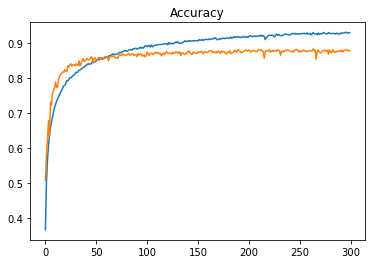

In [56]:
plt.title('Accuracy')
plt.plot(epoch_info.history['accuracy'])
plt.plot(epoch_info.history['val_accuracy'])

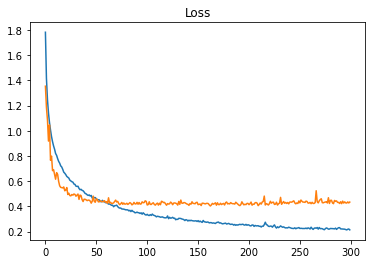

In [57]:
plt.title('Loss')
plt.plot(epoch_info.history['loss'])
plt.plot(epoch_info.history['val_loss'])

## Step-10: Summarize

In [58]:
print("------------------------TEST SET INFO---------------------------")
print("Test set Loss: " , info)
print("Test set Accuarcy: " , acc*100 , "%")

------------------------TEST SET INFO---------------------------
Test set Loss:  0.4338018298149109
Test set Accuarcy:  87.74999976158142 %
